<a href="https://colab.research.google.com/github/Kusalb/RNNs-for-stock-price-prediction/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

In [147]:
dataset = pd.read_csv("google.csv")
dataset

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...,...
4312,2021-10-05,2747.239990,2680.000000,2680.000000,2723.540039,1206300.0,2723.540039
4313,2021-10-06,2757.040039,2689.729980,2692.510010,2747.080078,988200.0,2747.080078
4314,2021-10-07,2803.089111,2771.260010,2777.260010,2783.709961,912500.0,2783.709961
4315,2021-10-08,2806.340088,2788.586914,2798.120117,2801.120117,946200.0,2801.120117


In [148]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4317 non-null   object 
 1   High       4317 non-null   float64
 2   Low        4317 non-null   float64
 3   Open       4317 non-null   float64
 4   Close      4317 non-null   float64
 5   Volume     4317 non-null   float64
 6   Adj Close  4317 non-null   float64
dtypes: float64(6), object(1)
memory usage: 236.2+ KB


In [149]:
dataset.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086


In [150]:
dataset.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4317.000000,4317.000000,4317.000000,4317.000000,4.317000e+03,4317.000000
mean,639.682936,627.615621,633.603748,633.852357,6.523837e+06,633.852357
std,561.783142,552.069438,556.527532,557.255541,7.830526e+06,557.255541
min,50.680038,47.800831,49.409801,49.818268,7.922000e+03,49.818268
25%,247.507278,241.469910,244.832306,244.334183,1.593563e+06,244.334183
50%,401.988251,395.168823,399.004425,398.561096,3.851583e+06,398.561096
75%,933.440002,923.030029,929.059998,928.799988,8.268878e+06,928.799988
max,2936.409912,2912.290039,2918.989990,2916.840088,8.254163e+07,2916.840088


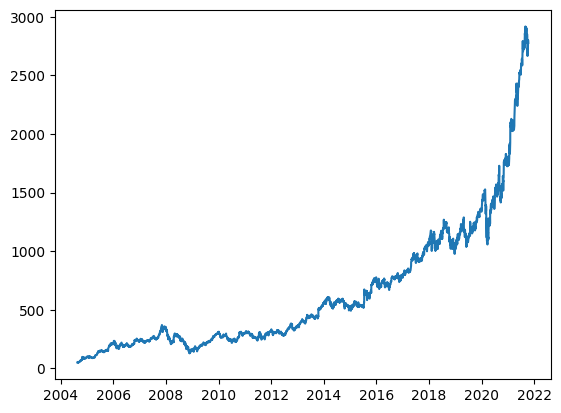

In [151]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
plt.plot(dataset['Date'], dataset['Close'])

In [152]:
dataset.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086


In [153]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df[['Close'] + [f'Close(t-{i})' for i in range(1, n_steps + 1)]]

lookback = 7
shifted_df = prepare_dataframe_for_lstm(dataset, lookback)
print(shifted_df)


                  Close   Close(t-1)   Close(t-2)   Close(t-3)   Close(t-4)  \
Date                                                                          
2004-08-30    50.814533    52.876804    53.753517    52.802086    52.239197   
2004-08-31    50.993862    50.814533    52.876804    53.753517    52.802086   
2004-09-01    49.937820    50.993862    50.814533    52.876804    53.753517   
2004-09-02    50.565468    49.937820    50.993862    50.814533    52.876804   
2004-09-03    49.818268    50.565468    49.937820    50.993862    50.814533   
...                 ...          ...          ...          ...          ...   
2021-10-05  2723.540039  2675.300049  2729.250000  2665.310059  2690.419922   
2021-10-06  2747.080078  2723.540039  2675.300049  2729.250000  2665.310059   
2021-10-07  2783.709961  2747.080078  2723.540039  2675.300049  2729.250000   
2021-10-08  2801.120117  2783.709961  2747.080078  2723.540039  2675.300049   
2021-10-11  2776.949951  2801.120117  2783.709961  2

In [154]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  50.81453323,   52.87680435,   53.75351715, ...,   54.49573517,
          53.95277023,   49.98265457],
       [  50.99386215,   50.81453323,   52.87680435, ...,   52.23919678,
          54.49573517,   53.95277023],
       [  49.93782043,   50.99386215,   50.81453323, ...,   52.80208588,
          52.23919678,   54.49573517],
       ...,
       [2783.70996094, 2747.08007812, 2723.54003906, ..., 2665.31005859,
        2690.41992188, 2723.67993164],
       [2801.12011719, 2783.70996094, 2747.08007812, ..., 2729.25      ,
        2665.31005859, 2690.41992188],
       [2776.94995117, 2801.12011719, 2783.70996094, ..., 2675.30004883,
        2729.25      , 2665.31005859]])

In [155]:
shifted_df_as_np.shape

(4310, 8)

In [156]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99930502, -0.9978664 , -0.99725482, ..., -0.99673705,
        -0.99711582, -0.99988533],
       [-0.99917992, -0.99930502, -0.9978664 , ..., -0.99831119,
        -0.99673705, -0.99711582],
       [-0.9999166 , -0.99917992, -0.99930502, ..., -0.99791852,
        -0.99831119, -0.99673705],
       ...,
       [ 0.90713002,  0.88157746,  0.86515621, ...,  0.82453567,
         0.84205201,  0.86525379],
       [ 0.91927514,  0.90713002,  0.88157746, ...,  0.86913941,
         0.82453567,  0.84205201],
       [ 0.90241432,  0.91927514,  0.90713002, ...,  0.83150457,
         0.86913941,  0.82453567]])

In [157]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((4310, 7), (4310,))

In [158]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99988533, -0.99711582, -0.99673705, ..., -0.99791852,
        -0.99725482, -0.9978664 ],
       [-0.99711582, -0.99673705, -0.99831119, ..., -0.99725482,
        -0.9978664 , -0.99930502],
       [-0.99673705, -0.99831119, -0.99791852, ..., -0.9978664 ,
        -0.99930502, -0.99917992],
       ...,
       [ 0.86525379,  0.84205201,  0.82453567, ...,  0.83150457,
         0.86515621,  0.88157746],
       [ 0.84205201,  0.82453567,  0.86913941, ...,  0.86515621,
         0.88157746,  0.90713002],
       [ 0.82453567,  0.86913941,  0.83150457, ...,  0.88157746,
         0.90713002,  0.91927514]])

In [159]:
split_index = int(len(X) * 0.80)

split_index

3448

In [160]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3448, 7), (862, 7), (3448,), (862,))

In [161]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3448, 7, 1), (862, 7, 1), (3448, 1), (862, 1))

In [162]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3448, 7, 1]),
 torch.Size([862, 7, 1]),
 torch.Size([3448, 1]),
 torch.Size([862, 1]))

In [163]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [164]:
train_dataset

In [165]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


torch.Size([16, 7, 1]) torch.Size([16, 1])


In [167]:
class GRU(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(GRU,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.gru = nn.GRU(input_size,hidden_size,num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #Initial hidden state
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.gru(x,h0)
    out = out[:, -1,:] # We use only the values in last step
    out = self.fc(out)
    return out

In [168]:
model = GRU(1, 5, 1)
model.to(device)
model

GRU(
  (gru): GRU(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [169]:
class StockPredictionTrainer:
    def __init__(self, model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.gradients = []
        self.mean_losses = []
        self.losses = []


    def run_training(self):
        for epoch in range(self.num_epochs):
            self.model.train(True)  # Set the model to training mode
            print(f'Epoch: {epoch + 1}')
            running_loss = 0.0
            gradients = []  # Store gradients for each epoch
            mean_losses =[]
            losses =[]
            for batch_index, batch in enumerate(self.train_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                output = self.model(x_batch)
                loss = self.loss_function(output, y_batch)
                running_loss += loss.item()

                self.optimizer.zero_grad()
                loss.backward()
                losses.append(loss.item())
                # Store gradients for each parameter in the model
                sum_gradients = 0
                number_parameters = 0

                for layers in self.model.gru.all_weights:
                    for weights in layers:
                        sum_gradients += weights.sum()
                        number_parameters += torch.numel(weights)

                mean_grad = sum_gradients / number_parameters
                self.gradients.append([mean_grad.detach().numpy()])


                self.optimizer.step()

                if batch_index % 100 == 99:  # print every 100 batches
                    avg_loss_across_batches = running_loss / 100
                    print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
                    running_loss = 0.0
            print()


            # Validation after each epoch
            self.model.train(False)  # Set the model to evaluation mode
            running_loss = 0.0

            for batch_index, batch in enumerate(self.test_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                with torch.no_grad():
                    output = self.model(x_batch)
                    loss = self.loss_function(output, y_batch)
                    running_loss += loss.item()

            avg_loss_across_batches = running_loss / len(self.test_loader)
            self.mean_losses.append(avg_loss_across_batches)
            self.losses.append(sum(losses)/len(losses))
            print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
            print('***************************************************')
            print()


    def calculate_mae(self, predictions, targets):
        return mean_absolute_error(targets, predictions)

    def calculate_and_print_mae(self, X_train, y_train, X_test, y_test):
        with torch.no_grad():
            predicted_train = self.model(X_train.to(device)).to('cpu').numpy()
            predicted_test = self.model(X_test.to(device)).detach().cpu().numpy().flatten()

        mae_train = self.calculate_mae(predicted_train, y_train.numpy())
        mae_test = self.calculate_mae(predicted_test, y_test.numpy())

        print(f'Mean Absolute Error in training: {mae_train}')
        print(f'Mean Absolute Error in testing: {mae_test}')

    def plot_predictions(self, X_train, y_train, X_test, y_test, lookback):
        with torch.no_grad():
            predicted_train = self.model(X_train.to(device)).to('cpu').numpy()
            predicted_test = self.model(X_test.to(device)).detach().cpu().numpy().flatten()

        train_predictions = dc(predicted_train[:, 0])
        test_predictions = dc(predicted_test)

        self.plot_results(y_train, train_predictions, "Training Set")
        self.plot_results(y_test, test_predictions, "Test Set")

    def plot_results(self, actual, predicted, title):
        dummies_actual = np.zeros((actual.shape[0], 1))
        dummies_actual[:, 0] = actual.flatten()
        actual_values = dc(dummies_actual[:, 0])

        dummies_predicted = np.zeros((predicted.shape[0], 1))
        dummies_predicted[:, 0] = predicted.flatten()
        predicted_values = dc(dummies_predicted[:, 0])

        plt.plot(actual_values, label='Actual Close')
        plt.plot(predicted_values, label='Predicted Close')
        plt.xlabel('Day')
        plt.ylabel('Close')
        plt.title(title)
        plt.legend()
        plt.show()


    def plot_gradients_losses(self):
        figure, axis = plt.subplots(1, 2,figsize=(15, 5))
        axis[0].plot(self.gradients)
        axis[0].set_title('Fit in training')
        axis[0].set_xlabel('Steps (Iterations)')
        axis[0].set_ylabel('Mean gradient value')
      # Plot validation vs. training loss
        axis[1].plot(self.losses, label='Training Loss')
        axis[1].plot(self.mean_losses, label='Validation Loss', color='orange')
        axis[1].set_title('Validation vs. Training Loss')
        axis[1].set_xlabel('Epochs')
        axis[1].set_ylabel('Loss value (mean)')
        axis[1].legend()

        plt.show()



In [170]:
learning_rate = 0.001
num_epochs=10
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)

In [171]:
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.272
Batch 200, Loss: 0.065

Val Loss: 0.918
***************************************************

Epoch: 2
Batch 100, Loss: 0.039
Batch 200, Loss: 0.036

Val Loss: 0.812
***************************************************

Epoch: 3
Batch 100, Loss: 0.034
Batch 200, Loss: 0.032

Val Loss: 0.716
***************************************************

Epoch: 4
Batch 100, Loss: 0.031
Batch 200, Loss: 0.029

Val Loss: 0.633
***************************************************

Epoch: 5
Batch 100, Loss: 0.026
Batch 200, Loss: 0.023

Val Loss: 0.457
***************************************************

Epoch: 6
Batch 100, Loss: 0.018
Batch 200, Loss: 0.009

Val Loss: 0.149
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000

Val Loss: 0.105
***************************************************

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.108
***************************************************



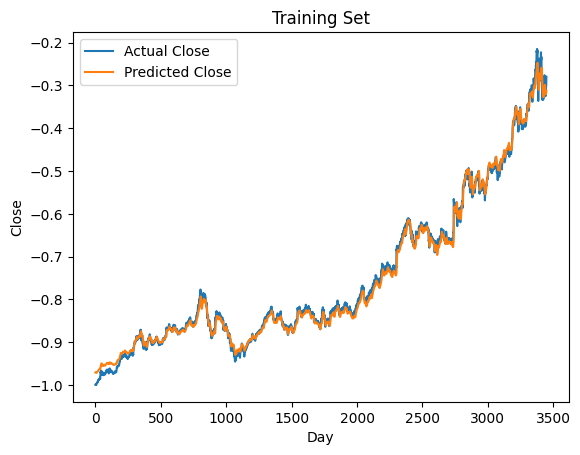

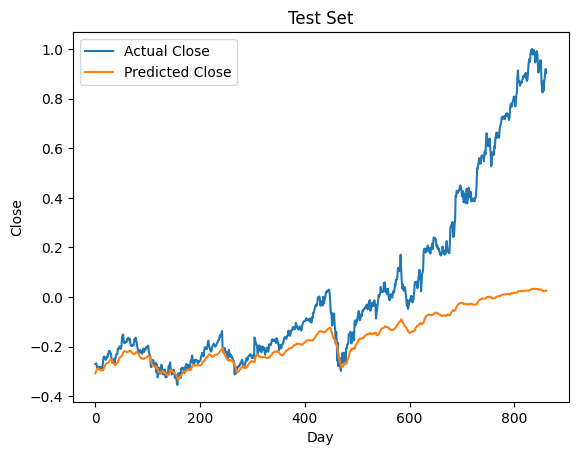

In [172]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

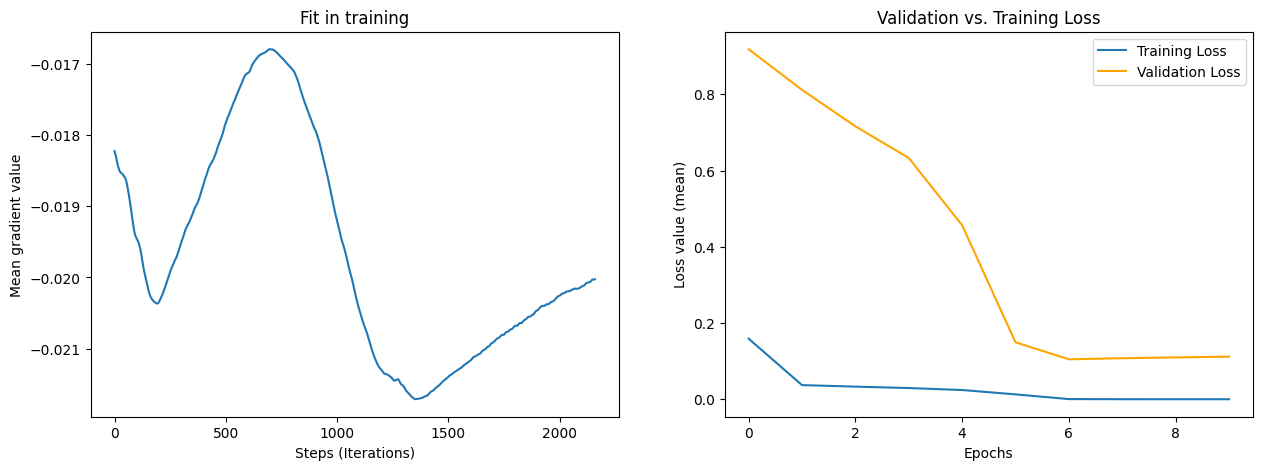

In [173]:
my_trainer.plot_gradients_losses()

In [174]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.008283962495625019
Mean Absolute Error in testing: 0.20235015451908112


In [175]:
learning_rate = 0.001
num_epochs = 20
model = GRU(1, 4, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.961
Batch 200, Loss: 0.252

Val Loss: 0.076
***************************************************

Epoch: 2
Batch 100, Loss: 0.032
Batch 200, Loss: 0.015

Val Loss: 0.163
***************************************************

Epoch: 3
Batch 100, Loss: 0.014
Batch 200, Loss: 0.012

Val Loss: 0.131
***************************************************

Epoch: 4
Batch 100, Loss: 0.011
Batch 200, Loss: 0.010

Val Loss: 0.093
***************************************************

Epoch: 5
Batch 100, Loss: 0.009
Batch 200, Loss: 0.008

Val Loss: 0.056
***************************************************

Epoch: 6
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005

Val Loss: 0.028
***************************************************

Epoch: 7
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.009
***************************************************

Epoch: 8
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001

Val Loss: 0.003
***************************************************



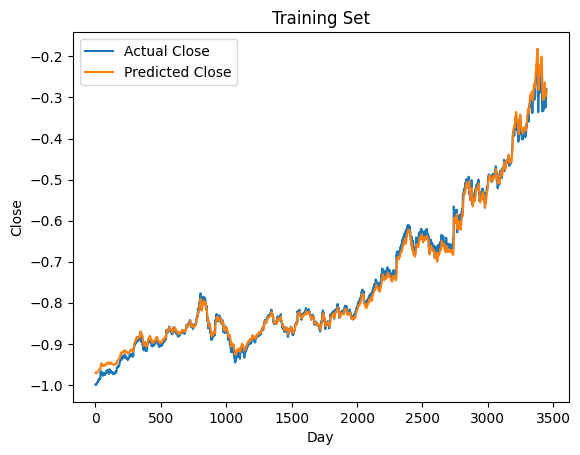

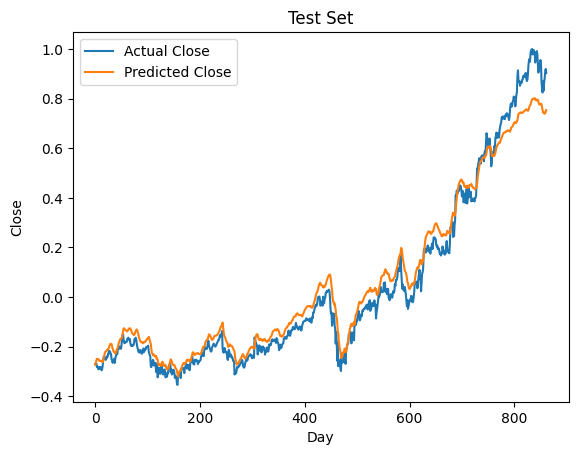

In [176]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

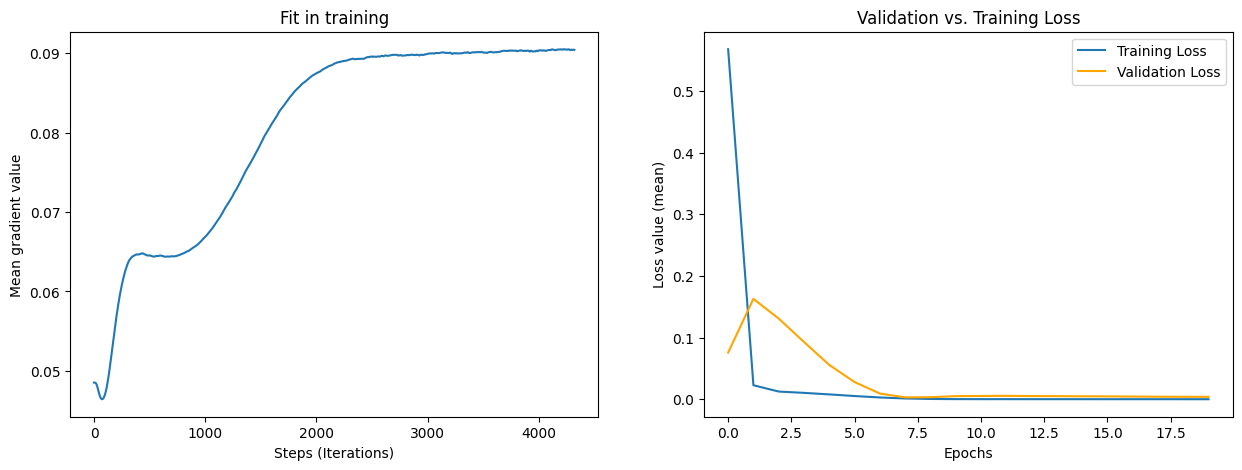

In [177]:
my_trainer.plot_gradients_losses()

In [178]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.009043161757290363
Mean Absolute Error in testing: 0.05105328932404518


In [179]:
learning_rate = 0.001
num_epochs = 30
model = GRU(1, 12, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.185
Batch 200, Loss: 0.018

Val Loss: 0.353
***************************************************

Epoch: 2
Batch 100, Loss: 0.013
Batch 200, Loss: 0.009

Val Loss: 0.153
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.000

Val Loss: 0.047
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.045
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.042
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.040
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.038
***************************************************

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.036
***************************************************



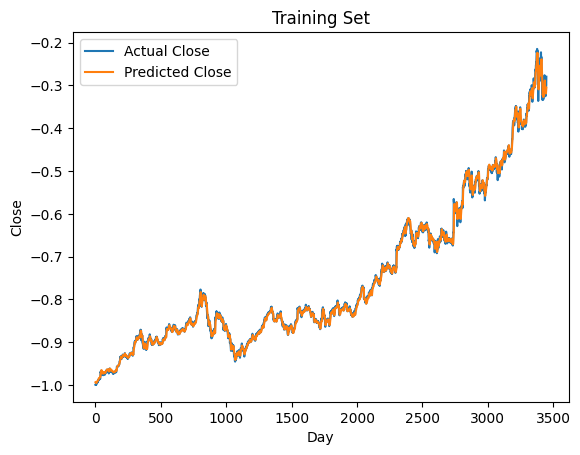

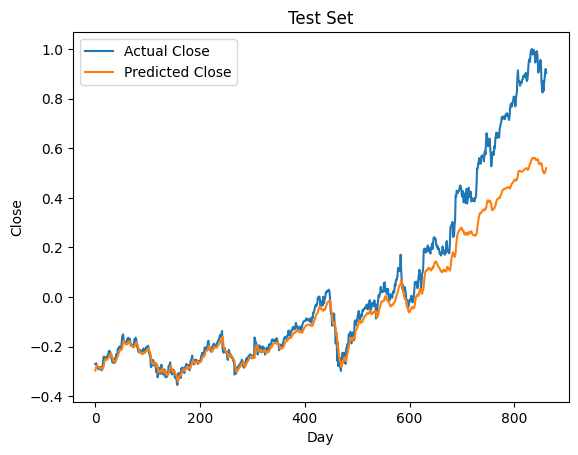

In [180]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

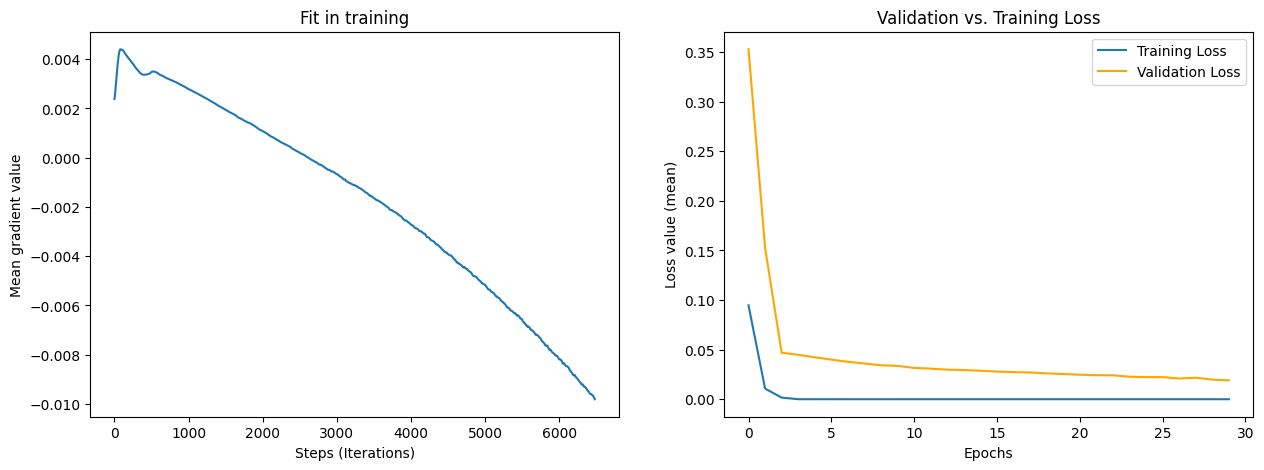

In [181]:
my_trainer.plot_gradients_losses()

In [182]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.004439987242221832
Mean Absolute Error in testing: 0.07880382239818573


In [183]:
learning_rate = 0.01
num_epochs = 30
model = GRU(1, 14, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.056
Batch 200, Loss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.008
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.009
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.009
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.010
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.010
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.009
***************************************************

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.009
***************************************************



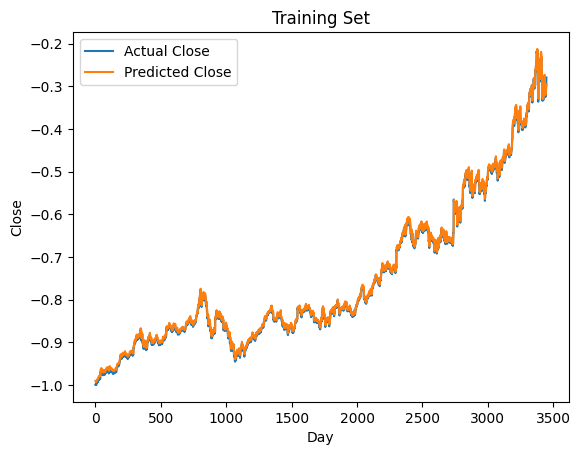

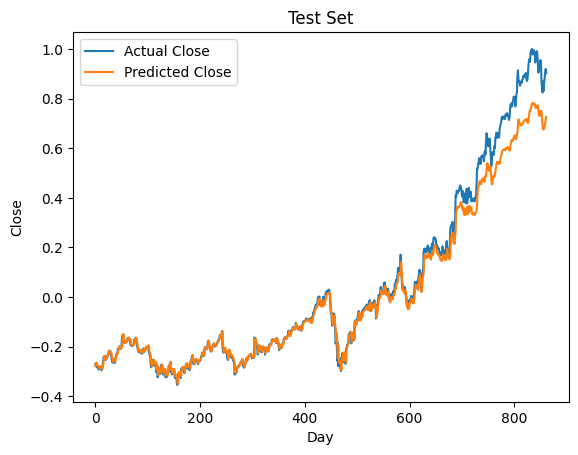

In [184]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

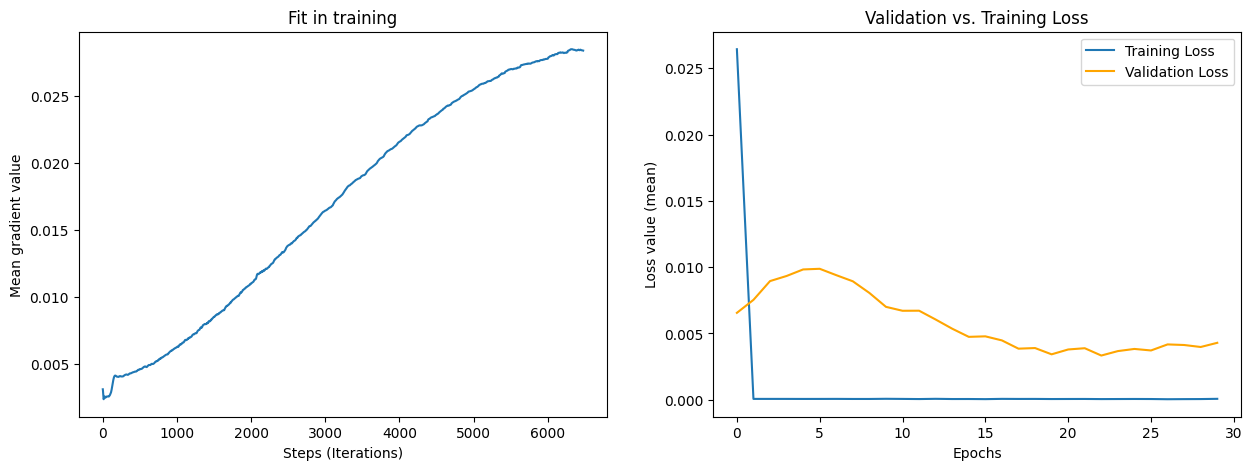

In [185]:
my_trainer.plot_gradients_losses()

In [186]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.004824087489396334
Mean Absolute Error in testing: 0.03725873678922653


In [187]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [188]:
learning_rate = 0.01
num_epochs = 50
model = GRU(1, 16, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.036

Val Loss: 0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.000

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 6
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 7
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 8
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 9
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.000

Val Loss: 0.007
********************************

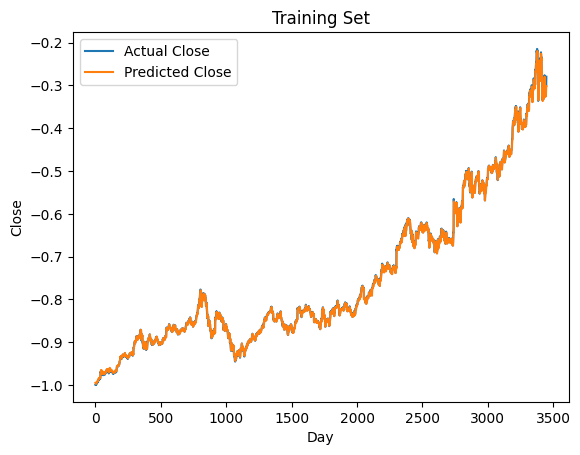

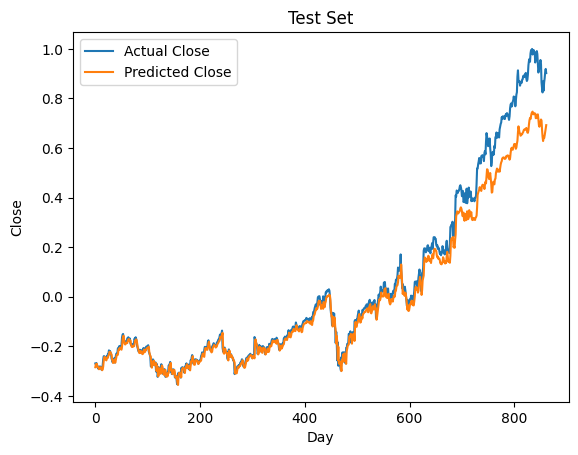

In [189]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

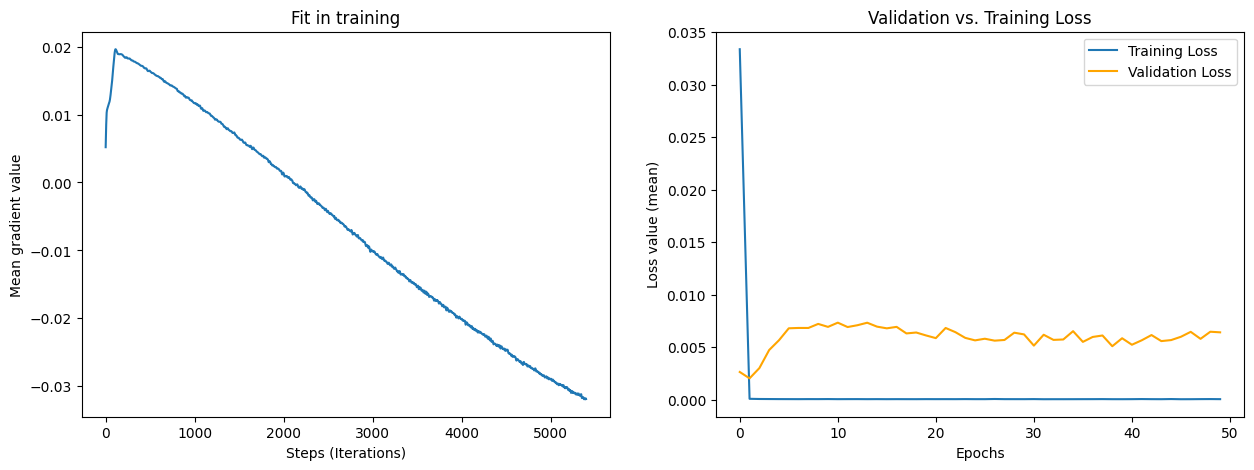

In [190]:
my_trainer.plot_gradients_losses()

In [191]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.003340629395097494
Mean Absolute Error in testing: 0.04644128680229187


In [192]:
learning_rate = 0.01
num_epochs = 50
model = GRU(1, 14, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1
Batch 100, Loss: 0.016

Val Loss: 0.004
***************************************************

Epoch: 2
Batch 100, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 3
Batch 100, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 5
Batch 100, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 6
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 7
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 8
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 9
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.000

Val Loss: 0.006
********************************

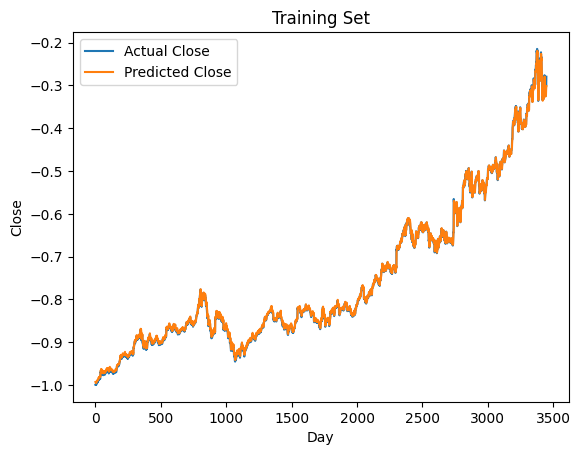

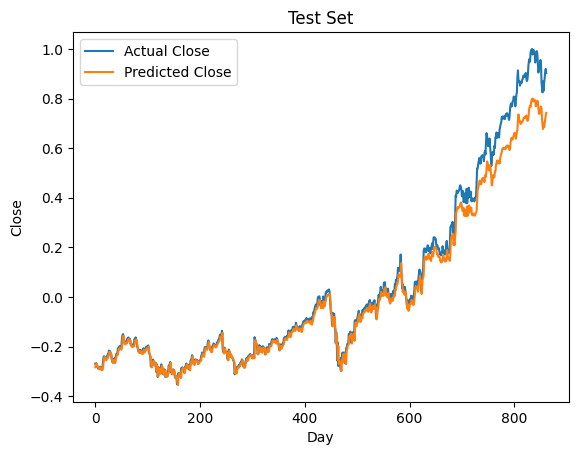

In [193]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

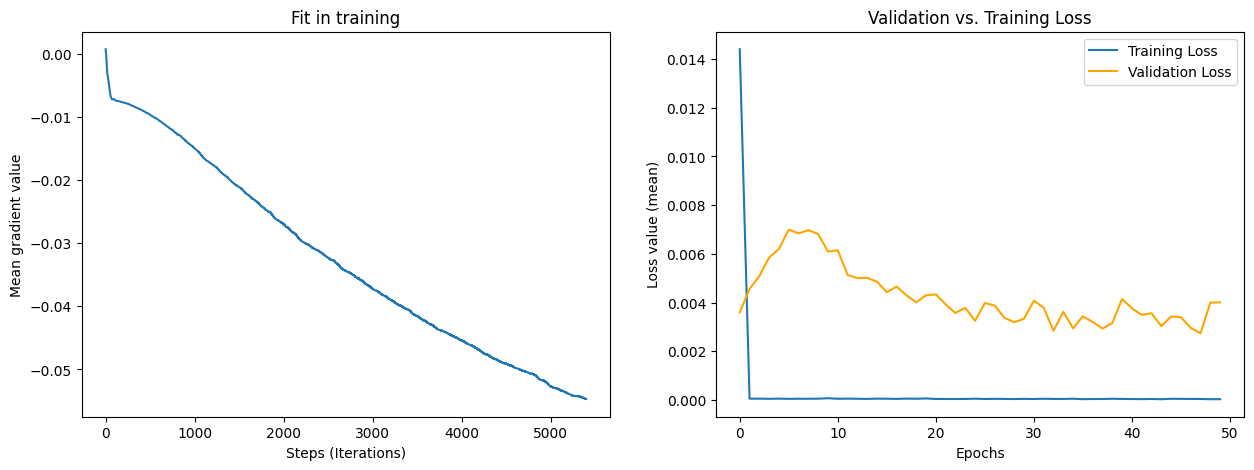

In [194]:
my_trainer.plot_gradients_losses()

In [195]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.00372598459944129
Mean Absolute Error in testing: 0.03811925649642944


Increasing Batch size

In [196]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [197]:
learning_rate = 0.01
num_epochs = 200
model = GRU(1, 14, 1)
model.to(device)
model
my_trainer = StockPredictionTrainer(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=learning_rate)
my_trainer.run_training()

Epoch: 1

Val Loss: 0.246
***************************************************

Epoch: 2

Val Loss: 0.052
***************************************************

Epoch: 3

Val Loss: 0.002
***************************************************

Epoch: 4

Val Loss: 0.002
***************************************************

Epoch: 5

Val Loss: 0.002
***************************************************

Epoch: 6

Val Loss: 0.003
***************************************************

Epoch: 7

Val Loss: 0.003
***************************************************

Epoch: 8

Val Loss: 0.003
***************************************************

Epoch: 9

Val Loss: 0.003
***************************************************

Epoch: 10

Val Loss: 0.004
***************************************************

Epoch: 11

Val Loss: 0.004
***************************************************

Epoch: 12

Val Loss: 0.004
***************************************************

Epoch: 13

Val Loss: 0.004
**********************

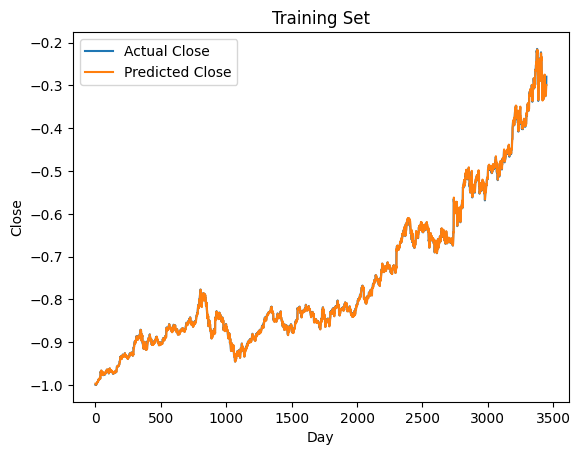

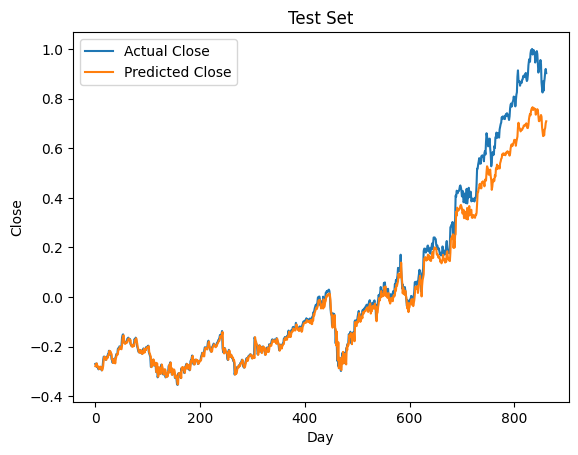

In [198]:
my_trainer.plot_predictions(X_train, y_train, X_test, y_test, lookback)

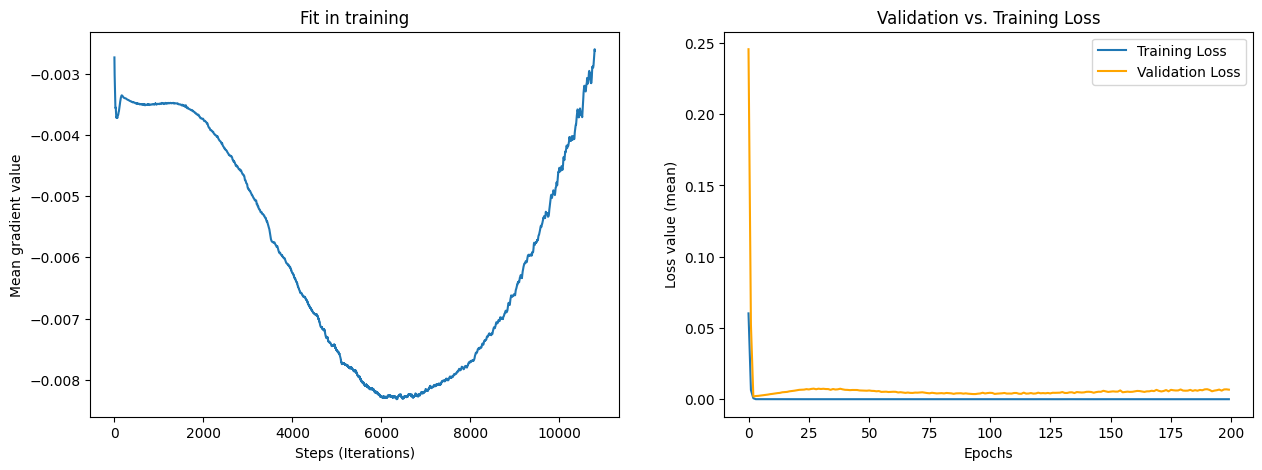

In [199]:
my_trainer.plot_gradients_losses()

In [200]:
my_trainer.calculate_and_print_mae(X_train, y_train, X_test, y_test)

Mean Absolute Error in training: 0.0032122309785336256
Mean Absolute Error in testing: 0.041727688163518906
